**Imports**

In [4]:
!pip install pandas textblob
!pip install scikit-learn
!pip install vaderSentiment
import nltk
nltk.download('punkt')
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

&nbsp;

**TestBlob**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Sentiment Distribution Table (in %):

sentiment   Negative  Neutral  Positive
#trump         15.87    54.57     29.57
#russia        17.07    52.77     30.16
#zelenskyy     13.86    48.02     38.12
#putin         17.46    51.85     30.69
#nafo           9.25    38.73     52.02


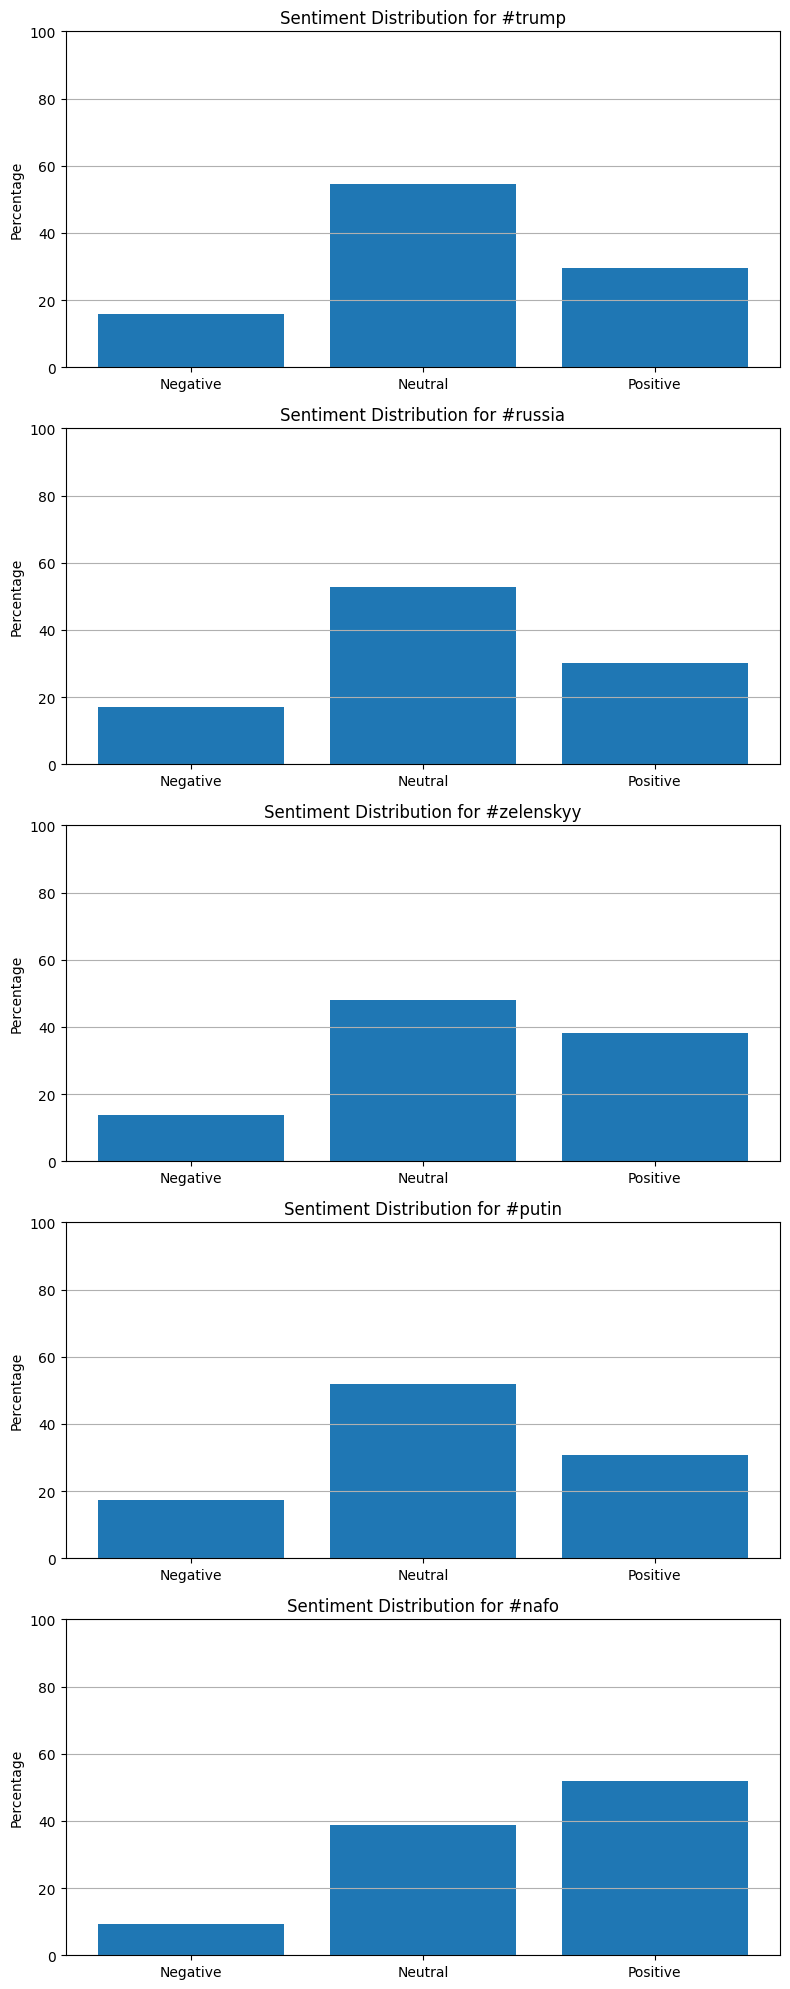

In [5]:
import pandas as pd
from textblob import TextBlob
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function to clean text
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Load the data
data = pd.read_json("bluesky-data.json")

# Preprocess the text
data['clean_text'] = data['text'].apply(preprocess_text)

# Compute polarity and sentiment using cleaned text
data['polarity'] = data['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
data['sentiment'] = data['polarity'].apply(
    lambda p: 'Positive' if p > 0.1 else 'Negative' if p < -0.1 else 'Neutral'
)

# Extract hashtags (excluding '#ukraine')
data['hashtags'] = data['text'].apply(
    lambda x: [tag.lower() for tag in re.findall(r"#\w+", x) if tag.lower() != "#ukraine"]
)

# Flatten hashtag list and count frequencies
all_tags = [tag for tags in data['hashtags'] for tag in tags]
top_tags = Counter(all_tags).most_common(5)
top_tag_names = [tag for tag, _ in top_tags]

# Analyze sentiment distribution for each top tag
tag_sentiments = {}
for tag in top_tag_names:
    tagged_data = data[data['hashtags'].apply(lambda tags: tag in tags)]
    sentiment_counts = tagged_data['sentiment'].value_counts(normalize=True) * 100
    tag_sentiments[tag] = sentiment_counts

# Convert to DataFrame and fill missing values
tag_sentiment_df = pd.DataFrame(tag_sentiments).fillna(0).T

# Display sentiment scores in a text-based table
print("Sentiment Distribution Table (in %):\n")
print(tag_sentiment_df.round(2).to_string())

# Plot sentiment distributions
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))
for i, tag in enumerate(tag_sentiment_df.index):
    sentiments = tag_sentiment_df.loc[tag]
    axes[i].bar(sentiments.index, sentiments.values)
    axes[i].set_title(f'Sentiment Distribution for {tag}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()


&nbsp;

**VADER**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


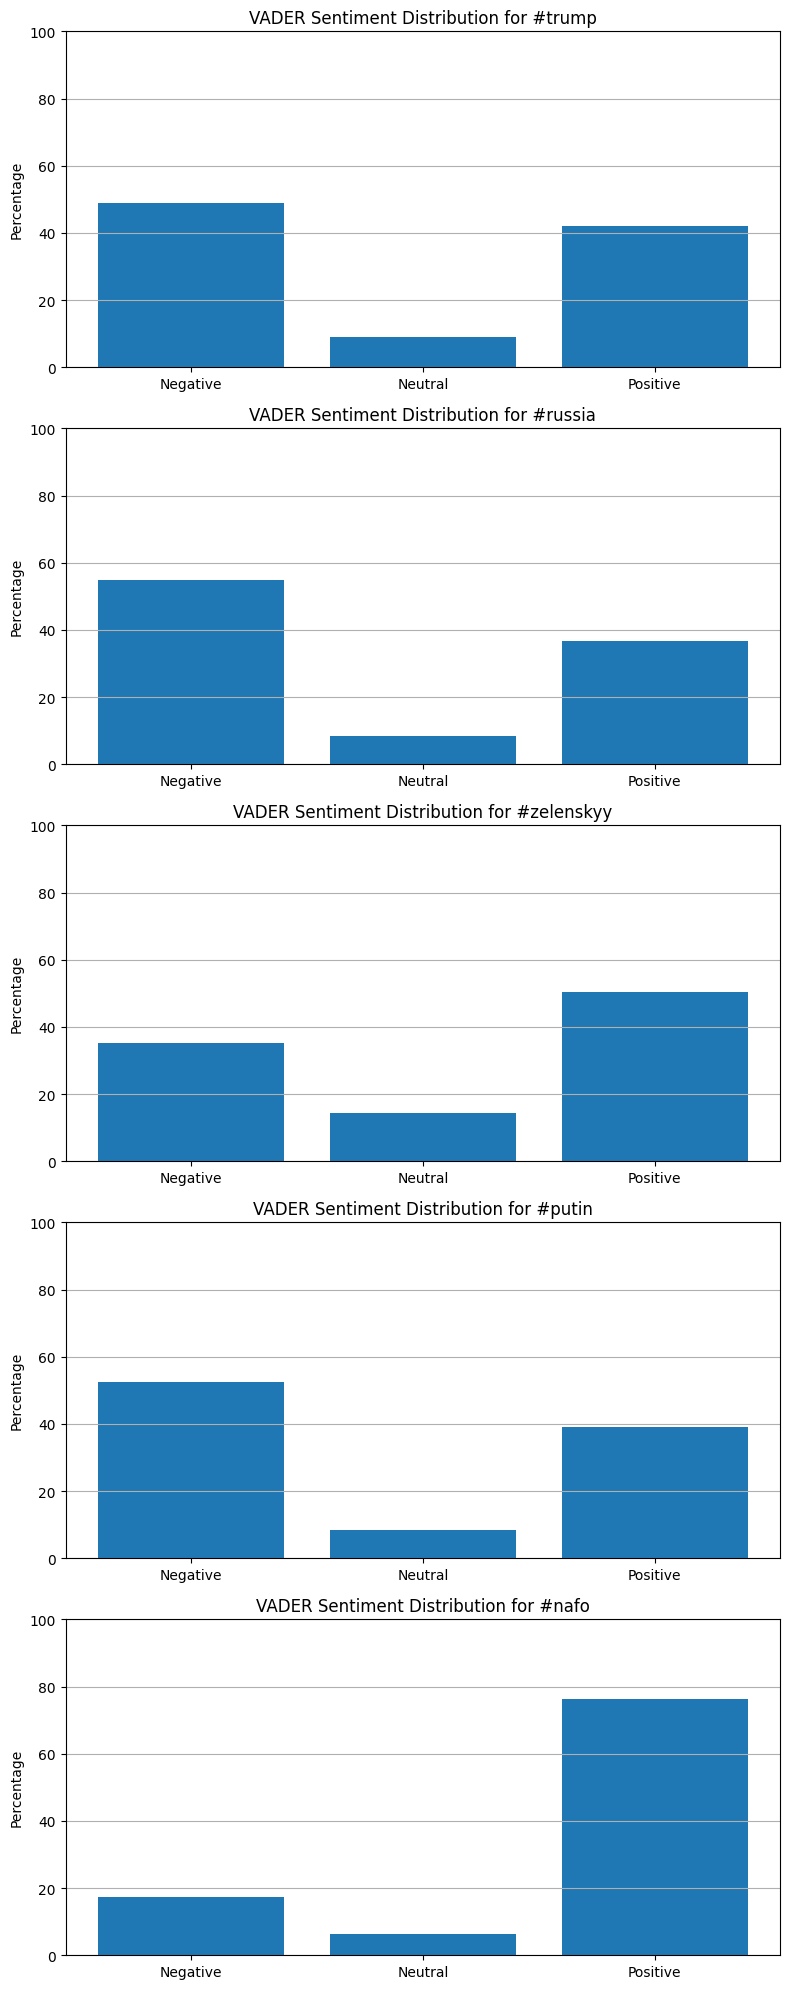

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocess text to clean and remove stopwords
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and non-letter characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Load the data
data = pd.read_json("bluesky-data.json")

# Preprocess the tweets
data['clean_text'] = data['text'].apply(preprocess_text)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# VADER sentiment classification function
def vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply VADER sentiment to preprocessed tweets
data['sentiment'] = data['clean_text'].apply(vader_sentiment)

# Extract hashtags (excluding '#ukraine')
data['hashtags'] = data['text'].apply(
    lambda x: [tag.lower() for tag in re.findall(r"#\w+", x) if tag.lower() != "#ukraine"]
)

# Get top 5 most common hashtags
all_tags = [tag for tags in data['hashtags'] for tag in tags]
top_tags = Counter(all_tags).most_common(5)
top_tag_names = [tag for tag, _ in top_tags]

# Sentiment distribution per tag
tag_sentiments = {}
for tag in top_tag_names:
    tagged_data = data[data['hashtags'].apply(lambda tags: tag in tags)]
    sentiment_counts = tagged_data['sentiment'].value_counts(normalize=True) * 100
    tag_sentiments[tag] = sentiment_counts

# Convert to DataFrame and fill missing values
tag_sentiment_df = pd.DataFrame(tag_sentiments).fillna(0).T

# Plot sentiment distributions for top hashtags
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))
for i, tag in enumerate(tag_sentiment_df.index):
    sentiments = tag_sentiment_df.loc[tag]
    axes[i].bar(sentiments.index, sentiments.values)
    axes[i].set_title(f'VADER Sentiment Distribution for {tag}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()


&nbsp;

**NKLT**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


VADER Sentiment Distribution Table (in %):

sentiment   Negative  Neutral  Positive
#trump         48.91     8.91     42.17
#russia        54.99     8.43     36.59
#zelenskyy     35.15    14.36     50.50
#putin         52.38     8.47     39.15
#nafo          17.34     6.36     76.30


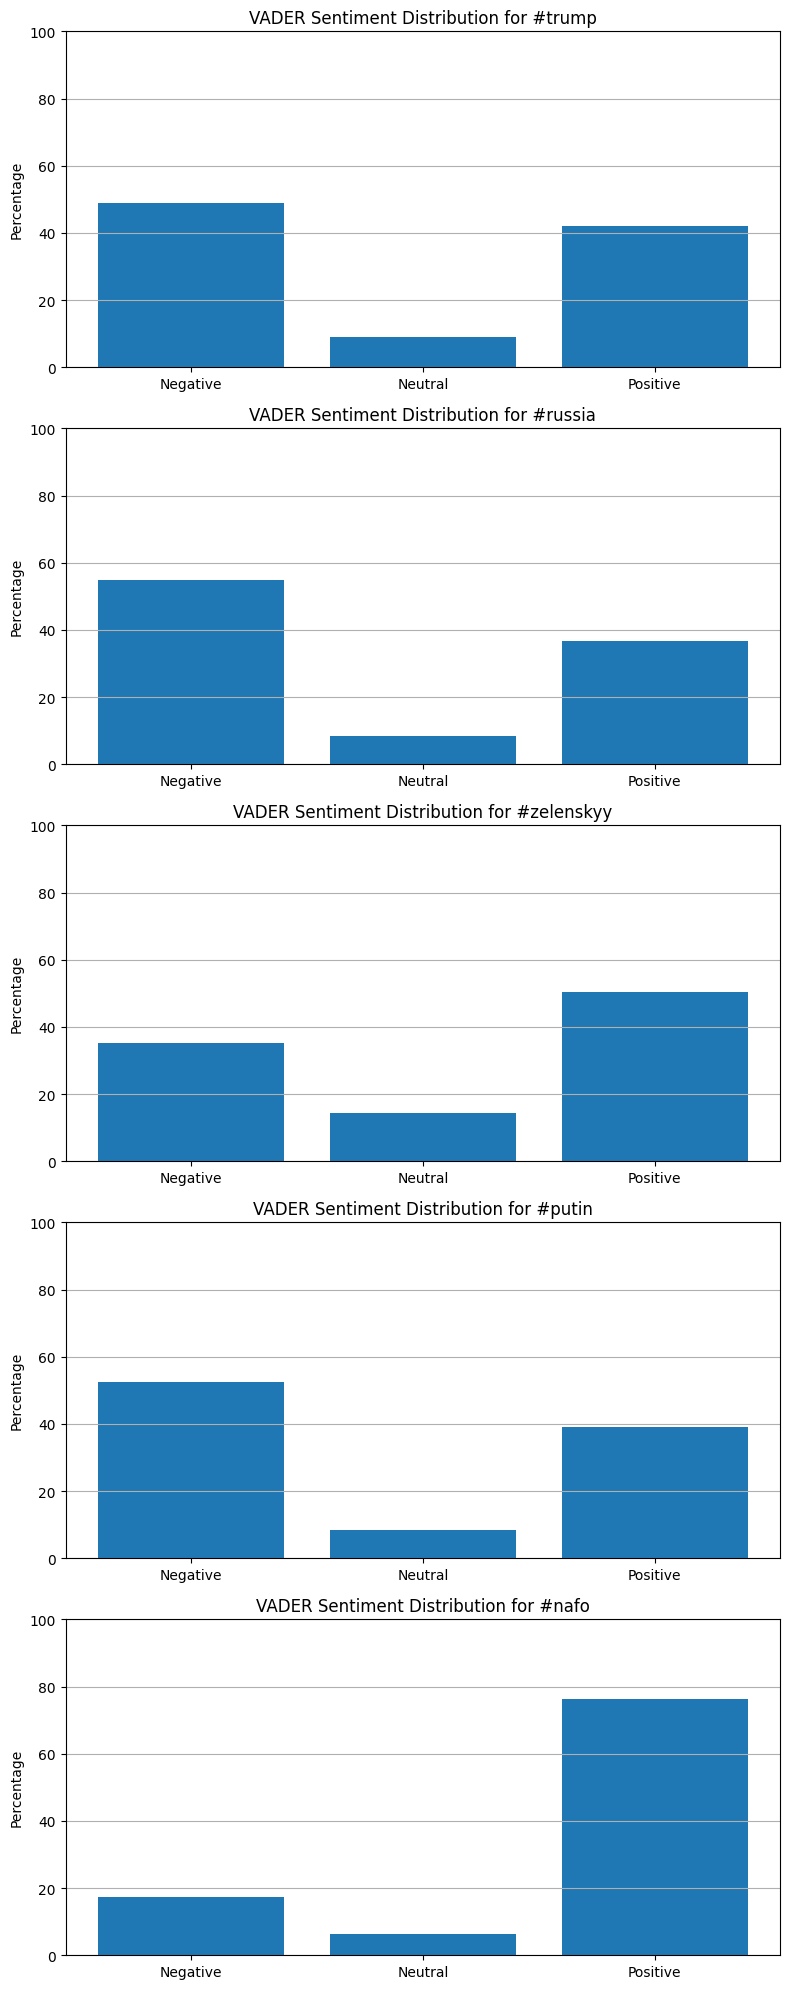

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if they are not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function: lowercases text, removes punctuation/non-letter characters, and removes stopwords
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and non-letter characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Load the data
data = pd.read_json("bluesky-data.json")

# Preprocess tweets and add as a new column
data['clean_text'] = data['text'].apply(preprocess_text)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# VADER sentiment classification function using preprocessed text
def vader_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply VADER sentiment to the cleaned tweets
data['sentiment'] = data['clean_text'].apply(vader_sentiment)

# Extract hashtags (excluding '#ukraine') from the original text
data['hashtags'] = data['text'].apply(
    lambda x: [tag.lower() for tag in re.findall(r"#\w+", x) if tag.lower() != "#ukraine"]
)

# Get top 5 most common hashtags
all_tags = [tag for tags in data['hashtags'] for tag in tags]
top_tags = Counter(all_tags).most_common(5)
top_tag_names = [tag for tag, _ in top_tags]

# Calculate sentiment distribution per tag
tag_sentiments = {}
for tag in top_tag_names:
    tagged_data = data[data['hashtags'].apply(lambda tags: tag in tags)]
    sentiment_counts = tagged_data['sentiment'].value_counts(normalize=True) * 100
    tag_sentiments[tag] = sentiment_counts

# Convert sentiment counts to DataFrame and fill missing values
tag_sentiment_df = pd.DataFrame(tag_sentiments).fillna(0).T

# Display sentiment scores in a text-based table
print("VADER Sentiment Distribution Table (in %):\n")
print(tag_sentiment_df.round(2).to_string())

# Plot sentiment distributions for top hashtags
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))
for i, tag in enumerate(tag_sentiment_df.index):
    sentiments = tag_sentiment_df.loc[tag]
    axes[i].bar(sentiments.index, sentiments.values)
    axes[i].set_title(f'VADER Sentiment Distribution for {tag}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_ylim(0, 100)
    axes[i].grid(axis='y')

plt.tight_layout()
plt.show()


&nbsp;

**Sentiment Classifier (scikit-learn + Naive Bayes)**

sentiment
Positive    2655
Negative     246
Neutral       99
Name: count, dtype: int64


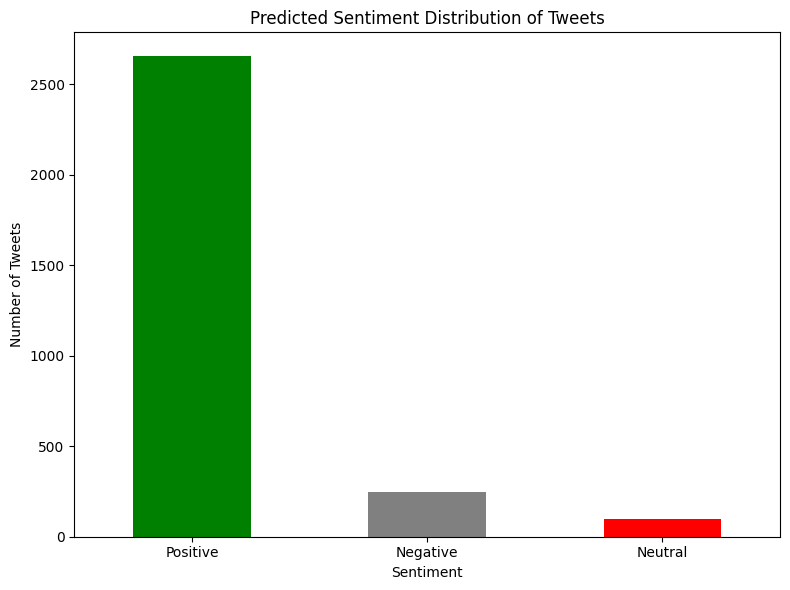

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already available
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation/non-letters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Training data
train_data = pd.DataFrame({
    'text': ['I love Ukraine', 'War is bad', 'Support is great', 'Hate war', 'We need peace'],
    'label': ['Positive', 'Negative', 'Positive', 'Negative', 'Neutral']
})

# Preprocess training text
train_data['clean_text'] = train_data['text'].apply(preprocess_text)

# Train the model using preprocessed text
X_train, y_train = train_data['clean_text'], train_data['label']
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

# Load actual tweet data
data = pd.read_json("bluesky-data.json")

# Preprocess tweet text
data['clean_text'] = data['text'].apply(preprocess_text)

# Predict sentiment using the trained model
data['sentiment'] = model.predict(data['clean_text'])

# Print predicted sentiment distribution
print(data['sentiment'].value_counts())

# Plot histogram of predicted sentiment distribution
plt.figure(figsize=(8, 6))
data['sentiment'].value_counts().plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("Predicted Sentiment Distribution of Tweets")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


&nbsp;

**Extra Credit**

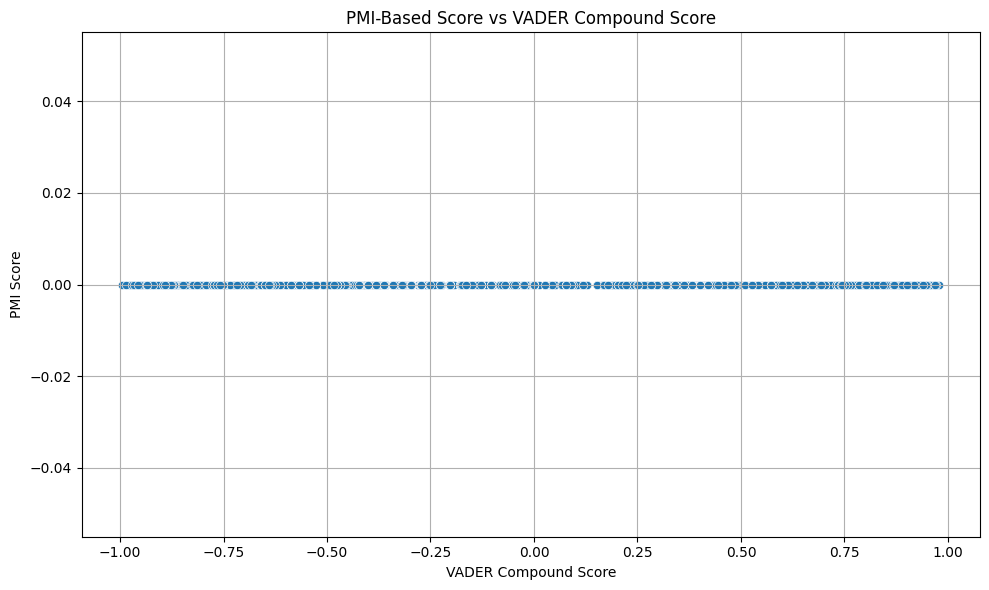

In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Download necessary resources
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and non-letter characters
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# STEP 1: Load and preprocess the data
df = pd.read_json('bluesky-data.json')
df['clean_text'] = df['text'].dropna().astype(str).apply(preprocess_text)
texts = df['clean_text'].tolist()

# STEP 2: VADER Sentiment Analysis (on cleaned text)
vader = SentimentIntensityAnalyzer()
vader_scores = [vader.polarity_scores(text)['compound'] for text in texts]

# STEP 3: PMI-based sentiment estimation
# Define basic positive/negative word lists
positive_words = {'good', 'great', 'happy', 'love', 'excellent', 'fortunate', 'correct', 'superior', 'win', 'support'}
negative_words = {'bad', 'terrible', 'sad', 'hate', 'poor', 'unfortunate', 'wrong', 'inferior', 'lose', 'attack'}

# Vectorize cleaned text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)
word_counts = np.asarray(X.sum(axis=0)).flatten()
vocab = np.array(vectorizer.get_feature_names_out())

# Word probabilities
total_words = word_counts.sum()
word_probs = word_counts / total_words
word_prob_dict = dict(zip(vocab, word_probs))

# Define PMI score calculation
def compute_pmi_score(text):
    tokens = [word for word in text.split() if word in word_prob_dict]
    if not tokens:
        return 0.0
    pmi_score = 0.0
    for token in tokens:
        prob = word_prob_dict.get(token, 1e-6)
        if token in positive_words:
            pmi_score += np.log2(prob / (prob))
        elif token in negative_words:
            pmi_score -= np.log2(prob / (prob))
    return pmi_score / len(tokens)

pmi_scores = [compute_pmi_score(text) for text in texts]

# STEP 4: Create a DataFrame for plotting
results_df = pd.DataFrame({
    'Text': texts,
    'VADER_Compound': vader_scores,
    'PMI_Score': pmi_scores
})

# STEP 5: Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='VADER_Compound', y='PMI_Score')
plt.title('PMI-Based Score vs VADER Compound Score')
plt.xlabel('VADER Compound Score')
plt.ylabel('PMI Score')
plt.grid(True)
plt.tight_layout()
plt.show()
